<a href="https://colab.research.google.com/github/phungthibacha/Python_Retail-Strategy-and-Analytics/blob/main/Quantium_Virtual_Internship_Retail_Strategy_and_Analytics_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 2: Select control stores

The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

In [ ]:
%pip install pandas
import pandas as pd
import numpy as np
# For visualizations
import matplotlib.pyplot as plt
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math
from datetime import datetime as dt
import seaborn as sns
from scipy.stats import t

In [ ]:
#Add a new month ID column in the data with the format yyyymm
df_transactions = pd.read_csv("QVI_data.csv")
df_transactions['DATE'] = pd.to_datetime(df_transactions['DATE'])
df_transactions['YEARMONTH'] = df_transactions['DATE'].dt.strftime('%Y%m')
df_transactions.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,2018-10-17,1,1000,1,5,natural chip compny seasalt175g,2,6.0,175,ncc,YOUNG SINGLES/COUPLES,Premium,201810
1,2019-05-14,1,1307,348,66,ccs nacho cheese 175g,3,6.3,175,ccs,MIDAGE SINGLES/COUPLES,Budget,201905
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken 170g,2,2.9,170,smiths,MIDAGE SINGLES/COUPLES,Budget,201905
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion 175g,5,15.0,175,smiths,MIDAGE SINGLES/COUPLES,Budget,201808
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili 150g,3,13.8,150,kettle,MIDAGE SINGLES/COUPLES,Budget,201808


For each store and month calculate total sales, number of customers, transactions per customer, chips per customer and the average price per unit.

In [ ]:
df_group_ms = df_transactions.groupby(['YEARMONTH', 'STORE_NBR']).agg(totSales=("TOT_SALES","sum"),
                               nCustomers=('LYLTY_CARD_NBR', 'nunique'),
                               tot_transactions =('TXN_ID','count'),
                                tot_qty = ('PROD_QTY','sum')).reset_index()
df_group_ms.head()

,YEARMONTH,STORE_NBR,totSales,nCustomers,tot_transactions,tot_qty
0,201807,1,188.9,47,49,58
1,201807,2,140.5,36,38,43
2,201807,3,1164.9,108,134,263
3,201807,4,1318.3,121,152,302
4,201807,5,763.8,86,111,222


In [ ]:
df_group_ms['nTxnPerCust'] = df_group_ms['tot_transactions']/df_group_ms['nCustomers']
df_group_ms['nChipsPerTxn'] = df_group_ms['tot_qty']/df_group_ms['tot_transactions']
df_group_ms['avgPricePerUnit'] = df_group_ms['totSales']/df_group_ms['tot_qty']
df_group_ms.head()

,YEARMONTH,STORE_NBR,totSales,nCustomers,tot_transactions,tot_qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,201807,1,188.9,47,49,58,1.042553,1.183673,3.256897
1,201807,2,140.5,36,38,43,1.055556,1.131579,3.267442
2,201807,3,1164.9,108,134,263,1.240741,1.962687,4.429278
3,201807,4,1318.3,121,152,302,1.256198,1.986842,4.365232
4,201807,5,763.8,86,111,222,1.290698,2.000000,3.440541


In [ ]:
# Stores with full observation periods(12 month)
obs_counts = df_group_ms["STORE_NBR"].value_counts()
full_idx = obs_counts[obs_counts == 12].index
storesWithFullObs = df_group_ms[df_group_ms["STORE_NBR"].isin(full_idx)]
storesWithFullObs.head(3)

,YEARMONTH,STORE_NBR,totSales,nCustomers,tot_transactions,tot_qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,201807,1,188.9,47,49,58,1.042553,1.183673,3.256897
1,201807,2,140.5,36,38,43,1.055556,1.131579,3.267442
2,201807,3,1164.9,108,134,263,1.240741,1.962687,4.429278


In [ ]:
#Filter to the pre-trial period and stores with full observation periods
# the trial period: Feb 2019
pre_trial_period = df_group_ms[df_group_ms.YEARMONTH.astype(int) < 201902]
pre_trial_period.head()

,YEARMONTH,STORE_NBR,totSales,nCustomers,tot_transactions,tot_qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,201807,1,188.9,47,49,58,1.042553,1.183673,3.256897
1,201807,2,140.5,36,38,43,1.055556,1.131579,3.267442
2,201807,3,1164.9,108,134,263,1.240741,1.962687,4.429278
3,201807,4,1318.3,121,152,302,1.256198,1.986842,4.365232
4,201807,5,763.8,86,111,222,1.290698,2.000000,3.440541


Now we need to work out a way of ranking how similar each potential control store
is to the trial store. We can calculate how correlated the performance of each
store is to the trial store.

In [ ]:
pre_trial_period = pre_trial_period.astype({"YEARMONTH":"int"})

In [ ]:
#Function to automate calculate the correlation between trial store and control store
def calculateCorrelation(inputTable, metricCol, storeComparison):

    """'inputTable'      as a metric table with potential comparison stores
       'metricCol'       as the store metric used to calculate correlation on
       'storeComparison' as the store number of the trial store."""

    control_all = inputTable.loc[~inputTable["STORE_NBR"].isin([77,86,88])] #other stores value except the trial stores values
    trial = inputTable.loc[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index()
    calcCorrTable = pd.DataFrame(columns = ["Control_Store", "Trial_Store", "Corr"])

    for i in control_all["STORE_NBR"].unique():
        control = control_all[control_all["STORE_NBR"]==i][metricCol].reset_index()
        correlation = control.corrwith(trial,axis=0)[1]
        calcCorrTable_i = pd.DataFrame({"Control_Store":i,"Trial_Store":storeComparison,"Corr":[correlation]})
        calcCorrTable = pd.concat([calcCorrTable, calcCorrTable_i])

    return calcCorrTable.sort_values(by='Control_Store', ascending=True)

Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store's performance and each control store's performance.

In [ ]:
def calculateMagnitudeDistance(inputTable, metricCol, storeComparison):

    """'inputTable'      as a metric table with potential comparison stores
       'metricCol'       as the store metric used to calculate correlation on
       'storeComparison' as the store number of the trial store."""

    control_all = inputTable.loc[~inputTable["STORE_NBR"].isin([77,86,88])] #other stores value except the trial stores values
    trial = inputTable.loc[inputTable["STORE_NBR"] == storeComparison].reset_index()[metricCol]
    calcDistTable = pd.DataFrame(columns=["Control_Store", "Trial_Store", "Magnitude"])

    for i in control_all["STORE_NBR"].unique():
        control = control_all[control_all["STORE_NBR"]==i].reset_index()[metricCol]
        diff = abs(trial - control)
        # Standardise the magnitude distance so that the measure ranges from 0 to 1
        #Magnitude measure = (1-(measure - minDistance)/(maxDistance - minDistance))
        #Finding the average magnitude measure after that
        s_diff = np.mean(1-((diff-min(diff))/(max(diff)-min(diff))))
        calcDistTable_i = pd.DataFrame({"Control_Store":i,"Trial_Store":[storeComparison],"Magnitude": s_diff})
        calcDistTable = pd.concat([calcDistTable, calcDistTable_i])
    return calcDistTable.sort_values(by='Control_Store', ascending=True)

Now let's use the functions to find the control stores! We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

# Select control stores

## 1) Store 77

In [ ]:
# calculate correlations against store 77 using total sales and number of customers
# total sales - corr
corr_nSales_77 = calculateCorrelation(pre_trial_period,"totSales",77)

# total sales - magnitude distance
magnitude_nSales_77 = calculateMagnitudeDistance(pre_trial_period,"totSales",77)

# number of customers - corr
corr_nCustomers_77 = calculateCorrelation(pre_trial_period,"nCustomers",77)

# number of customers - magnitude distance
magnitude_nCustomers_77 = calculateMagnitudeDistance(pre_trial_period,"nCustomers",77)

We'll need to combine the all the scores calculated using our function to create a
composite score to rank on.
- Let's take a simple average of the correlation and magnitude scores for each
driver. Note that if we consider it more important for the trend of the drivers to
be similar, we can increase the weight of the correlation score (a simple average
gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of
the drivers to be more important, we can lower the weight of the correlation score.

In [ ]:
#Finding which stores have the best related to store 77 based on total number of customers
# Merging the correlations table with the magnitude table - number of Customers
nSales_77_merge = pd.concat([corr_nSales_77,magnitude_nSales_77["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nSales_77_merge["score_nSales"] = corr_weight_b * nSales_77_merge["Corr"] + (1-corr_weight_b) * nSales_77_merge["Magnitude"]
nSales_77_merge.sort_values(by='score_nSales', ascending=False)

,Control_Store,Trial_Store,Corr,Magnitude,score_nSales
0,233,77,0.973643,0.584860,0.779251
0,71,77,0.815635,0.670699,0.743167
0,30,77,0.740401,0.648705,0.694553
0,50,77,0.897701,0.489159,0.693430
0,60,77,0.691252,0.631536,0.661394
...,...,...,...,...,...
0,76,77,NaN,NaN,NaN
0,85,77,NaN,NaN,NaN
0,193,77,NaN,NaN,NaN
0,206,77,NaN,NaN,NaN


In [ ]:
#Finding which stores have the best related to store 77 based on total number of customers
# Merging the correlations table with the magnitude table - number of Customers
nCustomers_77_merge = pd.concat([corr_nCustomers_77,magnitude_nCustomers_77["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nCustomers_77_merge["score_nCustomers"] = corr_weight_b * nCustomers_77_merge["Corr"] + (1-corr_weight_b) * nCustomers_77_merge["Magnitude"]
nCustomers_77_merge.sort_values(by='score_nCustomers', ascending=False)

,Control_Store,Trial_Store,Corr,Magnitude,score_nCustomers
0,233,77,0.965682,0.785714,0.875698
0,50,77,0.709398,0.785714,0.747556
0,119,77,0.919064,0.571429,0.745246
0,178,77,0.787521,0.654762,0.721142
0,157,77,0.832839,0.602041,0.717440
...,...,...,...,...,...
0,76,77,NaN,NaN,NaN
0,85,77,NaN,NaN,NaN
0,193,77,NaN,NaN,NaN
0,206,77,NaN,NaN,NaN


In [ ]:
# Now we have a score for each of total number of sales and number of customers.
# Let's combine the two via a simple average.
# Merging the total Customers score table and the total sale amounts table
final_control_store_77 = pd.concat([nCustomers_77_merge,nSales_77_merge["score_nSales"]],axis=1)
# Calculate a combined score - number of Customers
corr_weight_b = 0.5
final_control_store_77["final_score"] = corr_weight_b * final_control_store_77["score_nCustomers"] + (1-corr_weight_b) * final_control_store_77["score_nSales"]
final_control_store_77.sort_values(by='final_score', ascending=False)
#The store with the highest score will be chosen as the control store since it most similar to the trial store

,Control_Store,Trial_Store,Corr,Magnitude,score_nCustomers,score_nSales,final_score
0,233,77,0.965682,0.785714,0.875698,0.779251,0.827475
0,50,77,0.709398,0.785714,0.747556,0.693430,0.720493
0,162,77,0.811532,0.587302,0.699417,0.655914,0.677665
0,71,77,0.642299,0.571429,0.606864,0.743167,0.675015
0,119,77,0.919064,0.571429,0.745246,0.594545,0.669896
...,...,...,...,...,...,...,...
0,76,77,NaN,NaN,NaN,NaN,NaN
0,85,77,NaN,NaN,NaN,NaN,NaN
0,193,77,NaN,NaN,NaN,NaN,NaN
0,206,77,NaN,NaN,NaN,NaN,NaN


Store 233 is the control store for trial store 77

 Let's visual check on trends based on the drivers to make sure calculation are correct

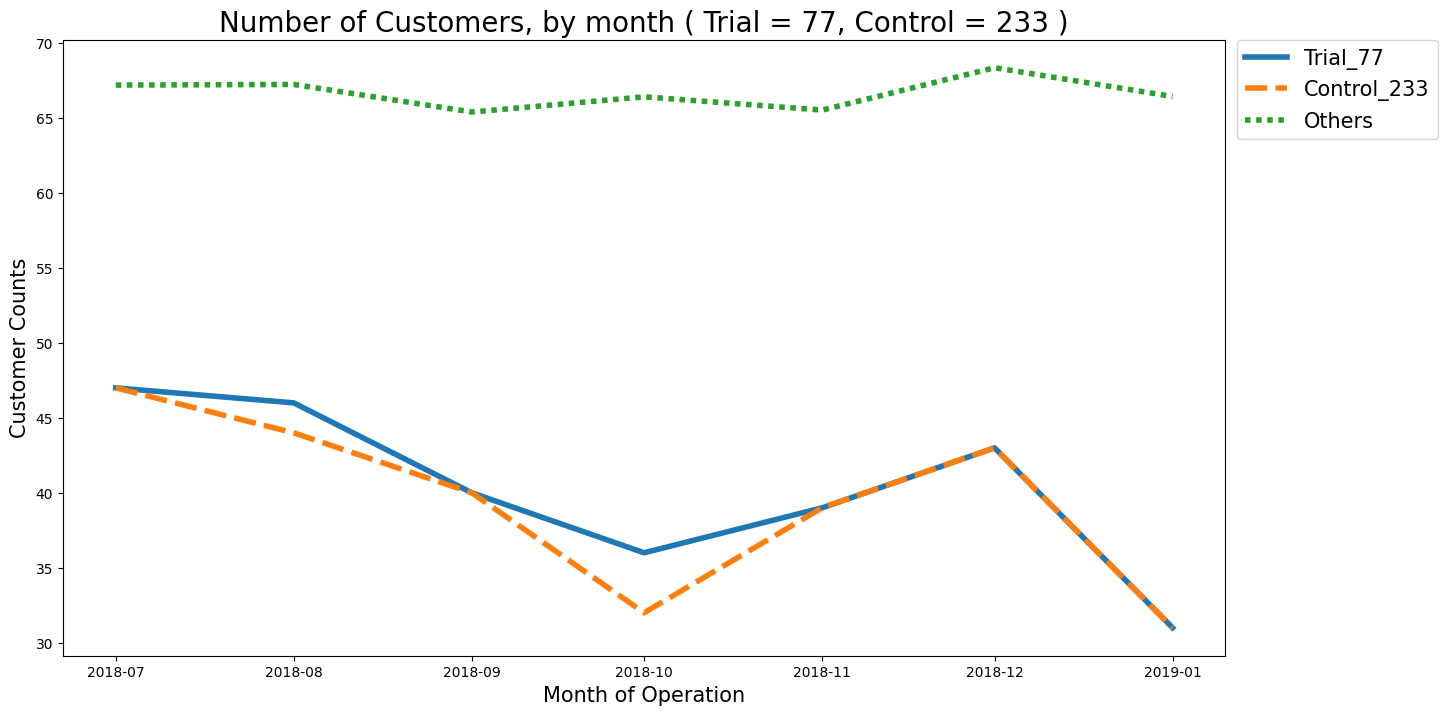

In [ ]:
# Visual checks on trends based on the drivers - number of customers
b = pre_trial_period.set_index(["YEARMONTH","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [77, 233]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_77_c = b.loc[:,([77,233,"others"])].reset_index()
paired_77_c["YEARMONTH"]= pd.to_datetime(paired_77_c["YEARMONTH"], format="%Y%m")
paired_77_c = paired_77_c.set_index(["YEARMONTH"])
paired_77_c.columns=["Trial_77","Control_233","Others"]
paired_77_c.to_csv('no_cust_77_233.csv', index = False)

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 77, Control = 233 )",fontsize=20)
sns.lineplot(data=paired_77_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

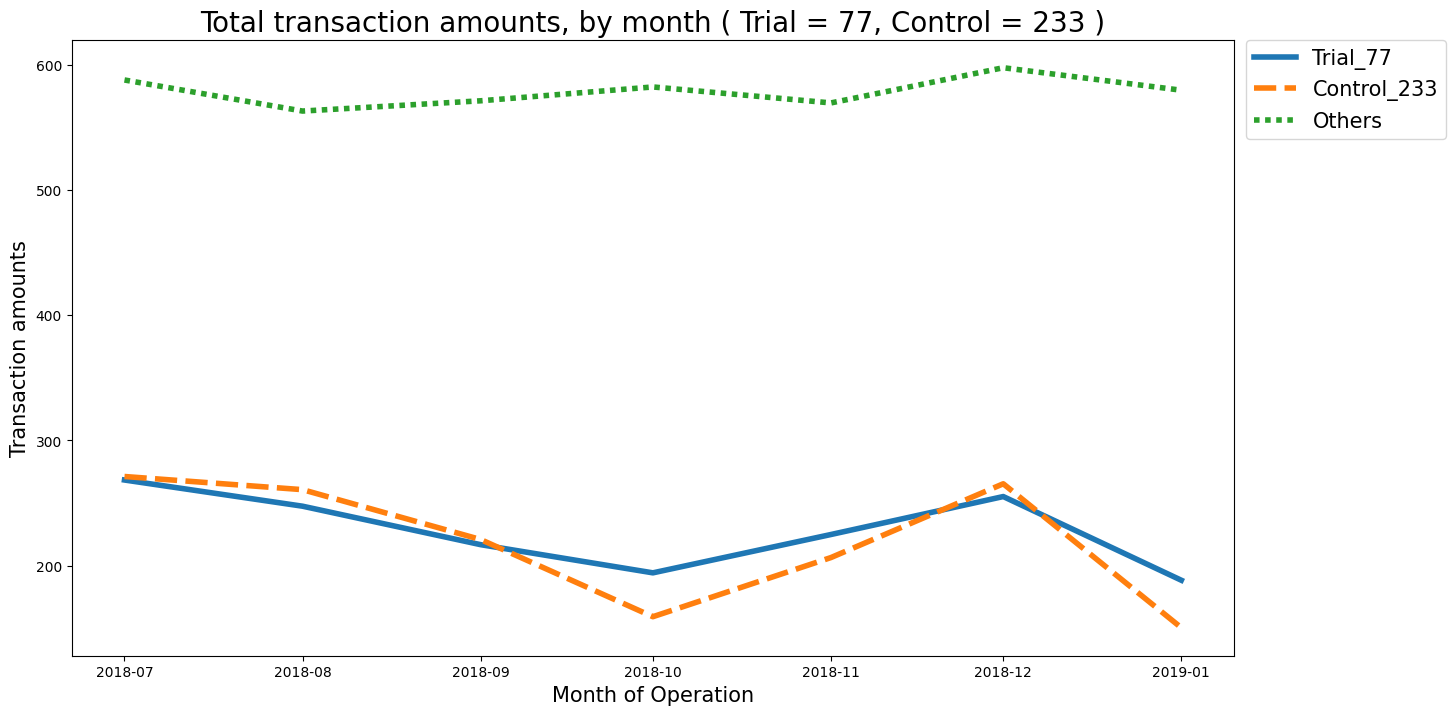

In [ ]:
# Visual checks on trends based on the drivers - total transaction amount
b = pre_trial_period.set_index(["YEARMONTH","STORE_NBR"])["totSales"].unstack()
others_col = [i for i in b.columns if i not in [77, 233]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_77_c = b.loc[:,([77,233,"others"])].reset_index()
paired_77_c["YEARMONTH"]= pd.to_datetime(paired_77_c["YEARMONTH"], format="%Y%m")
paired_77_c = paired_77_c.set_index(["YEARMONTH"])
paired_77_c.columns=["Trial_77","Control_233","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Total transaction amounts, by month ( Trial = 77, Control = 233 )",fontsize=20)
sns.lineplot(data=paired_77_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Transaction amounts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

## 2) Store 86

In [ ]:
# calculate correlations against store 86 using total sales and number of customers
# total sales - corr
corr_nSales_86 = calculateCorrelation(pre_trial_period,"totSales",86)

# total sales - magnitude distance
magnitude_nSales_86 = calculateMagnitudeDistance(pre_trial_period,"totSales",86)

# number of customers - corr
corr_nCustomers_86 = calculateCorrelation(pre_trial_period,"nCustomers",86)

# number of customers - magnitude distance
magnitude_nCustomers_86 = calculateMagnitudeDistance(pre_trial_period,"nCustomers",86)

In [ ]:
#Finding which stores have the best related to store 86 based on total number of customers
# Merging the correlations table with the magnitude table - number of Customers
nSales_86_merge = pd.concat([corr_nSales_86,magnitude_nSales_86["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nSales_86_merge["score_nSales"] = corr_weight_b * nSales_86_merge["Corr"] + (1-corr_weight_b) * nSales_86_merge["Magnitude"]
nSales_86_merge.sort_values(by='score_nSales', ascending=False)

,Control_Store,Trial_Store,Corr,Magnitude,score_nSales
0,155,86,0.869532,0.723319,0.796426
0,106,86,0.682060,0.713163,0.697611
0,114,86,0.750924,0.620936,0.685930
0,232,86,0.692945,0.668045,0.680495
0,181,86,0.674798,0.641330,0.658064
...,...,...,...,...,...
0,76,86,NaN,NaN,NaN
0,85,86,NaN,NaN,NaN
0,193,86,NaN,NaN,NaN
0,206,86,NaN,NaN,NaN


In [ ]:
#Finding which stores have the best related to store 86 based on total number of customers
# Merging the correlations table with the magnitude table - number of Customers
nCustomers_86_merge = pd.concat([corr_nCustomers_86,magnitude_nCustomers_86["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nCustomers_86_merge["score_nCustomers"] = corr_weight_b * nCustomers_86_merge["Corr"] + (1-corr_weight_b) * nCustomers_86_merge["Magnitude"]
nCustomers_86_merge.sort_values(by='score_nCustomers', ascending=False)

,Control_Store,Trial_Store,Corr,Magnitude,score_nCustomers
0,225,86,0.787599,0.634921,0.711260
0,78,86,0.776887,0.585714,0.681301
0,56,86,0.676956,0.660714,0.668835
0,114,86,0.855045,0.482143,0.668594
0,36,86,0.581028,0.723810,0.652419
...,...,...,...,...,...
0,76,86,NaN,NaN,NaN
0,85,86,NaN,NaN,NaN
0,193,86,NaN,NaN,NaN
0,206,86,NaN,NaN,NaN


In [ ]:
# Now we have a score for each of total number of sales and number of customers.
# Let's combine the two via a simple average.
# Merging the total Customers score table and the total sale amounts table
final_control_store_86 = pd.concat([nCustomers_86_merge,nSales_86_merge["score_nSales"]],axis=1)
# Calculate a combined score - number of Customers
corr_weight_b = 0.5
final_control_store_86["final_score"] = corr_weight_b * final_control_store_86["score_nCustomers"] + (1-corr_weight_b) * final_control_store_86["score_nSales"]
final_control_store_86.sort_values(by='final_score', ascending=False)
#The store with the highest score will be chosen as the control store since it most similar to the trial store

,Control_Store,Trial_Store,Corr,Magnitude,score_nCustomers,score_nSales,final_score
0,155,86,0.829086,0.357143,0.593114,0.796426,0.694770
0,114,86,0.855045,0.482143,0.668594,0.685930,0.677262
0,56,86,0.676956,0.660714,0.668835,0.606289,0.637562
0,181,86,0.468038,0.741497,0.604767,0.658064,0.631415
0,138,86,0.621938,0.523810,0.572874,0.639929,0.606401
...,...,...,...,...,...,...,...
0,76,86,NaN,NaN,NaN,NaN,NaN
0,85,86,NaN,NaN,NaN,NaN,NaN
0,193,86,NaN,NaN,NaN,NaN,NaN
0,206,86,NaN,NaN,NaN,NaN,NaN


We choose store 155 is the control store for store 86. Let's visualize to check carefully

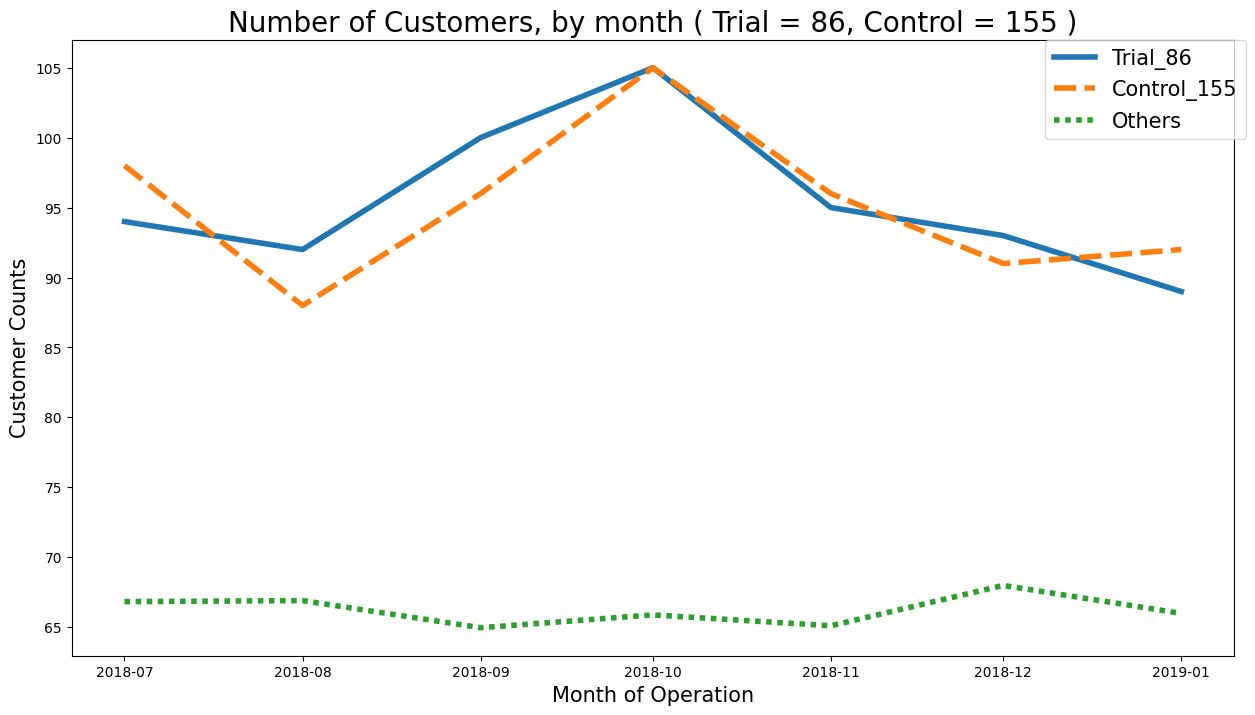

In [ ]:
# Visual checks on trends based on the drivers - number of customers
b = pre_trial_period.set_index(["YEARMONTH","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [86, 155]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_86_c = b.loc[:,([86,155,"others"])].reset_index()
paired_86_c["YEARMONTH"]= pd.to_datetime(paired_86_c["YEARMONTH"], format="%Y%m")
paired_86_c = paired_86_c.set_index(["YEARMONTH"])
paired_86_c.columns=["Trial_86","Control_155","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 86, Control = 155 )",fontsize=20)
sns.lineplot(data=paired_86_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

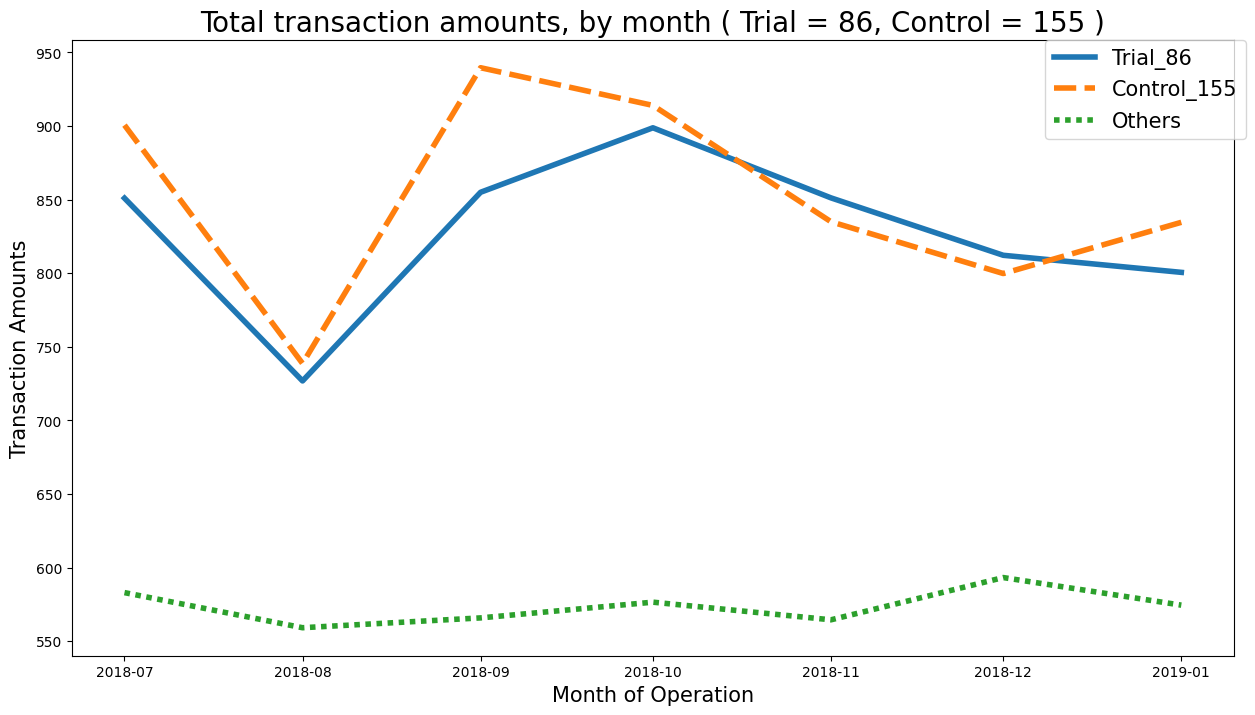

In [ ]:
# Visual checks on trends based on the drivers - total transaction amounts
b = pre_trial_period.set_index(["YEARMONTH","STORE_NBR"])["totSales"].unstack()
others_col = [i for i in b.columns if i not in [86, 155]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_86_c = b.loc[:,([86,155,"others"])].reset_index()
paired_86_c["YEARMONTH"]= pd.to_datetime(paired_86_c["YEARMONTH"], format="%Y%m")
paired_86_c = paired_86_c.set_index(["YEARMONTH"])
paired_86_c.columns=["Trial_86","Control_155","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Total transaction amounts, by month ( Trial = 86, Control = 155 )",fontsize=20)
sns.lineplot(data=paired_86_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Transaction Amounts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

## 3) Store 88

In [ ]:
# calculate correlations against store 88 using total sales and number of customers
# total sales - corr
corr_nSales_88 = calculateCorrelation(pre_trial_period,"totSales",88)

# total sales - magnitude distance
magnitude_nSales_88 = calculateMagnitudeDistance(pre_trial_period,"totSales",88)

# number of customers - corr
corr_nCustomers_88 = calculateCorrelation(pre_trial_period,"nCustomers",88)

# number of customers - magnitude distance
magnitude_nCustomers_88 = calculateMagnitudeDistance(pre_trial_period,"nCustomers",88)

In [ ]:
#Finding which stores have the best related to store 88 based on total number of customers
# Merging the correlations table with the magnitude table - number of Customers
nSales_88_merge = pd.concat([corr_nSales_88,magnitude_nSales_88["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nSales_88_merge["score_nSales"] = corr_weight_b * nSales_88_merge["Corr"] + (1-corr_weight_b) * nSales_88_merge["Magnitude"]
nSales_88_merge.sort_values(by='score_nSales', ascending=False)

,Control_Store,Trial_Store,Corr,Magnitude,score_nSales
0,159,88,0.938775,0.619311,0.779043
0,91,88,0.911986,0.632201,0.772093
0,204,88,0.871969,0.637441,0.754705
0,11,88,1.000000,0.500000,0.750000
0,31,88,1.000000,0.500000,0.750000
...,...,...,...,...,...
0,76,88,NaN,NaN,NaN
0,85,88,NaN,NaN,NaN
0,193,88,NaN,NaN,NaN
0,206,88,NaN,NaN,NaN


In [ ]:
#Finding which stores have the best related to store 88 based on total number of customers
# Merging the correlations table with the magnitude table - number of Customers
nCustomers_88_merge = pd.concat([corr_nCustomers_88,magnitude_nCustomers_88["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nCustomers_88_merge["score_nCustomers"] = corr_weight_b * nCustomers_88_merge["Corr"] + (1-corr_weight_b) * nCustomers_88_merge["Magnitude"]
nCustomers_88_merge.sort_values(by='score_nCustomers', ascending=False)

,Control_Store,Trial_Store,Corr,Magnitude,score_nCustomers
0,237,88,0.958896,0.738095,0.848496
0,178,88,0.908365,0.476190,0.692278
0,14,88,0.967364,0.392857,0.680111
0,233,88,0.783867,0.571429,0.677648
0,57,88,0.792889,0.561905,0.677397
...,...,...,...,...,...
0,76,88,NaN,NaN,NaN
0,85,88,NaN,NaN,NaN
0,193,88,NaN,NaN,NaN
0,206,88,NaN,NaN,NaN


In [ ]:
# Now we have a score for each of total number of sales and number of customers.
# Let's combine the two via a simple average.
# Merging the total Customers score table and the total sale amounts table
final_control_store_88 = pd.concat([nCustomers_88_merge,nSales_88_merge["score_nSales"]],axis=1)
# Calculate a combined score - number of Customers
corr_weight_b = 0.5
final_control_store_88["final_score"] = corr_weight_b * final_control_store_88["score_nCustomers"] + (1-corr_weight_b) * final_control_store_88["score_nSales"]
final_control_store_88.sort_values(by='final_score', ascending=False)
#The store with the highest score will be chosen as the control store since it most similar to the trial store

,Control_Store,Trial_Store,Corr,Magnitude,score_nCustomers,score_nSales,final_score
0,14,88,0.967364,0.392857,0.680111,0.582315,0.631213
0,237,88,0.958896,0.738095,0.848496,0.351820,0.600158
0,204,88,0.458144,0.392857,0.425501,0.754705,0.590103
0,159,88,0.249259,0.527473,0.388366,0.779043,0.583704
0,134,88,0.494603,0.494505,0.494554,0.646918,0.570736
...,...,...,...,...,...,...,...
0,76,88,NaN,NaN,NaN,NaN,NaN
0,85,88,NaN,NaN,NaN,NaN,NaN
0,193,88,NaN,NaN,NaN,NaN,NaN
0,206,88,NaN,NaN,NaN,NaN,NaN


Store 14 is chosen to be the control store for trial store 88, but we need to visualize to check it first

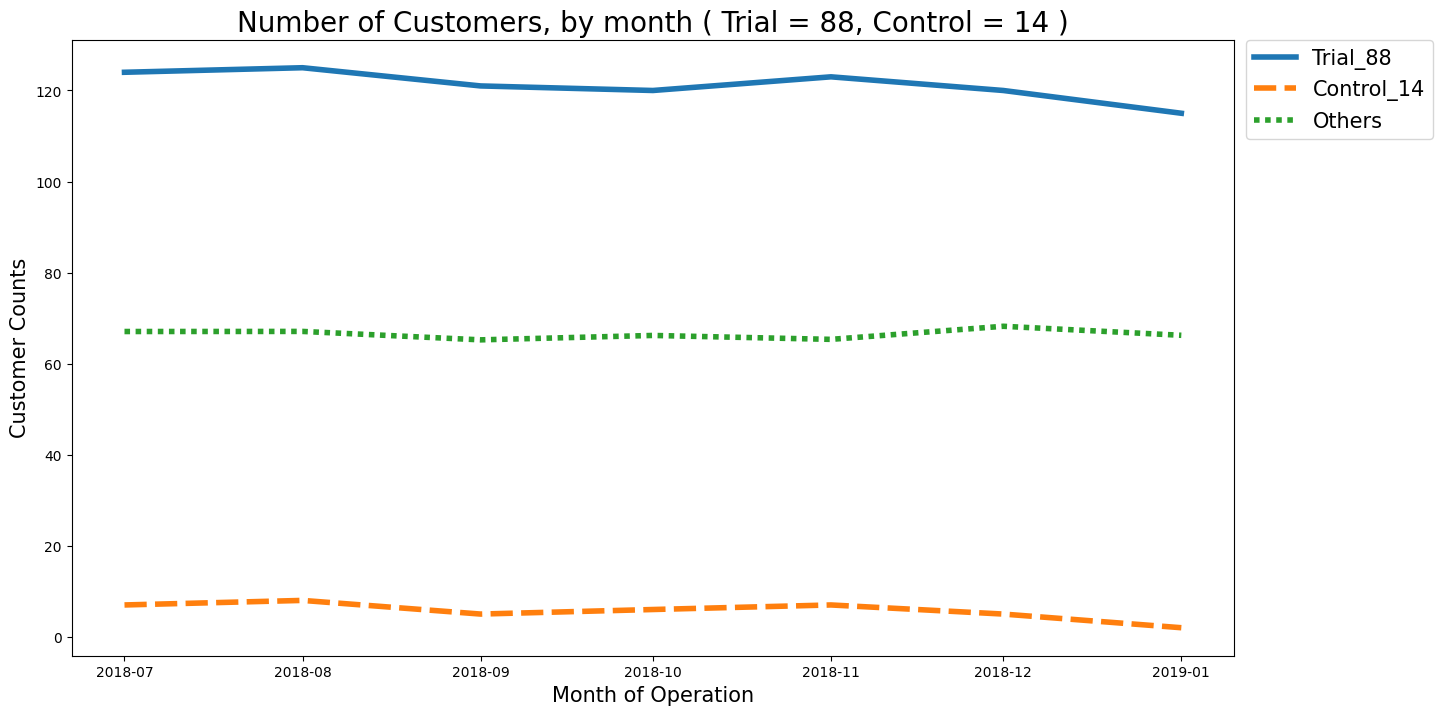

In [ ]:
# Visual checks on trends based on the drivers - number of customers
b = pre_trial_period.set_index(["YEARMONTH","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [88, 14]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_88_c = b.loc[:,([88,14,"others"])].reset_index()
paired_88_c["YEARMONTH"]= pd.to_datetime(paired_88_c["YEARMONTH"], format="%Y%m")
paired_88_c = paired_88_c.set_index(["YEARMONTH"])
paired_88_c.columns=["Trial_88","Control_14","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 88, Control = 14 )",fontsize=20)
sns.lineplot(data=paired_88_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

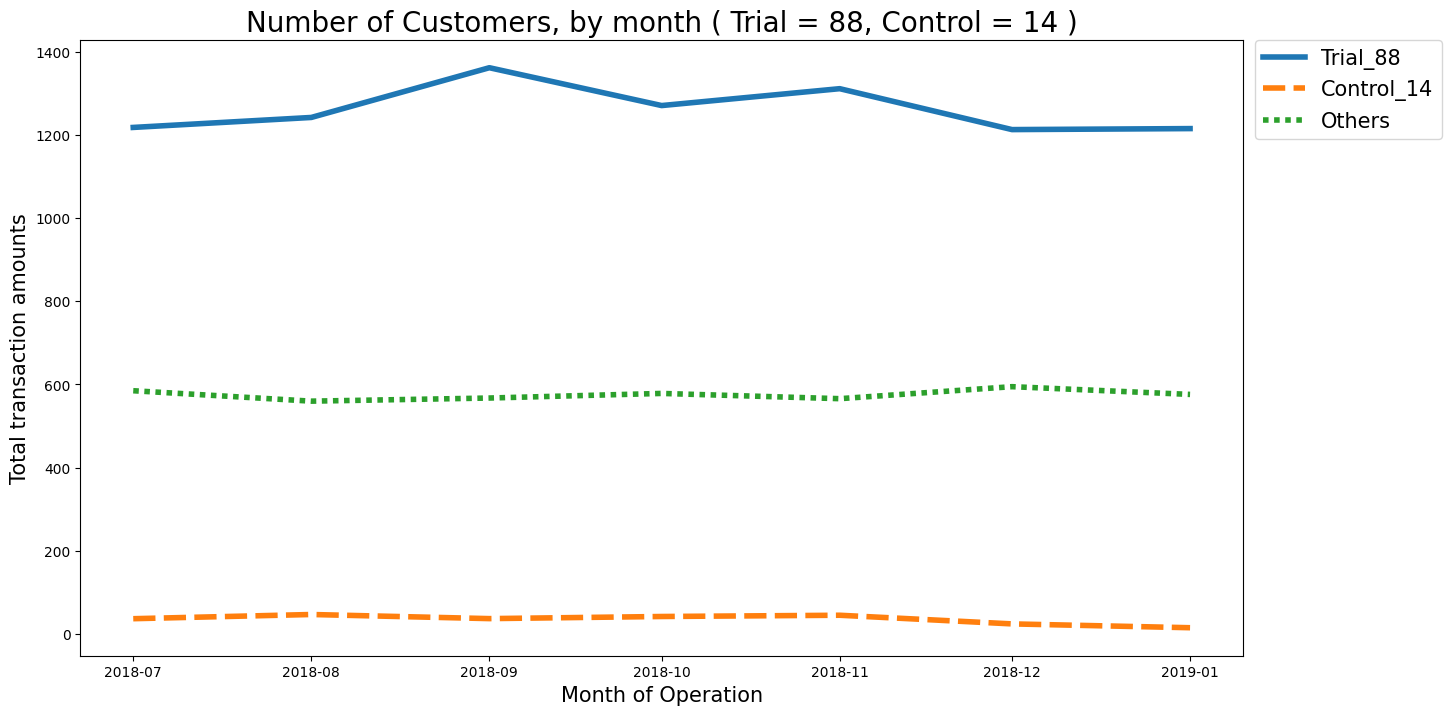

In [ ]:
# Visual checks on trends based on the drivers - total transaction amounts
b = pre_trial_period.set_index(["YEARMONTH","STORE_NBR"])["totSales"].unstack()
others_col = [i for i in b.columns if i not in [88, 14]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_88_c = b.loc[:,([88,14,"others"])].reset_index()
paired_88_c["YEARMONTH"]= pd.to_datetime(paired_88_c["YEARMONTH"], format="%Y%m")
paired_88_c = paired_88_c.set_index(["YEARMONTH"])
paired_88_c.columns=["Trial_88","Control_14","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 88, Control = 14 )",fontsize=20)
sns.lineplot(data=paired_88_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total transaction amounts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

Store 14 is not a suitable store for the control store of trial store 88. We consider to choose the second on the rank: store 237

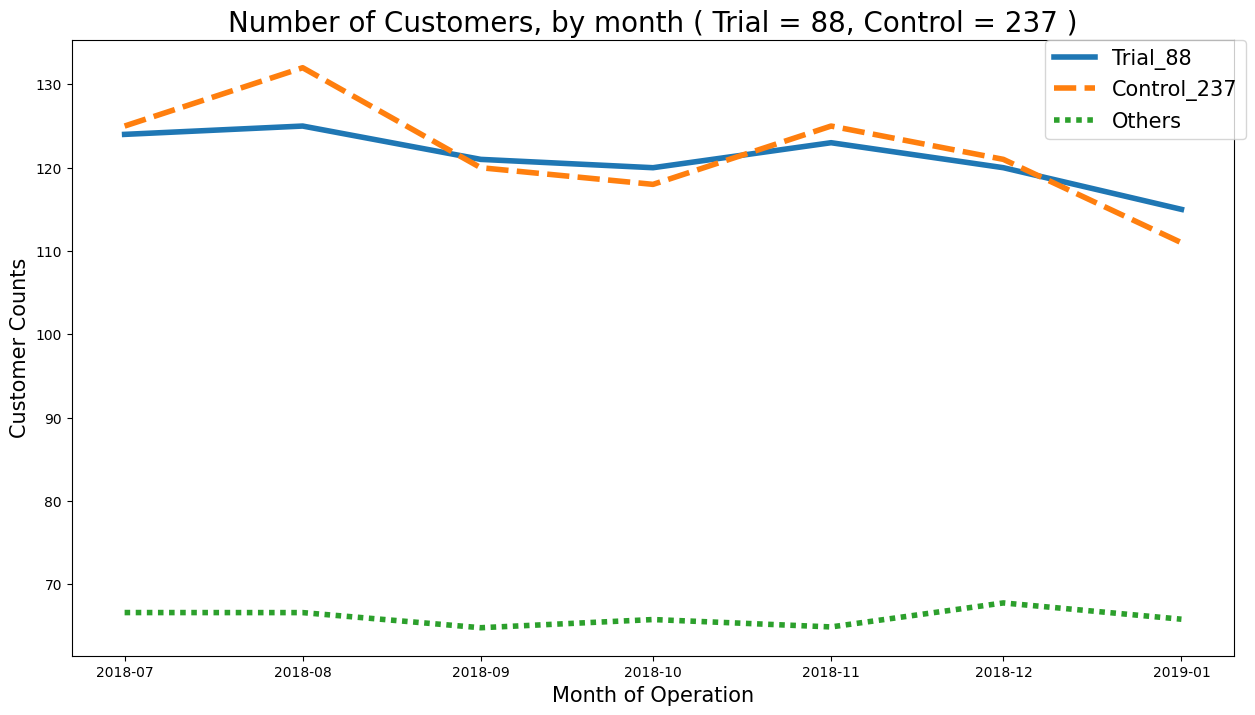

In [ ]:
# Visual checks on trends based on the drivers - number of customers
b = pre_trial_period.set_index(["YEARMONTH","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [88, 237]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_88_c = b.loc[:,([88,237,"others"])].reset_index()
paired_88_c["YEARMONTH"]= pd.to_datetime(paired_88_c["YEARMONTH"], format="%Y%m")
paired_88_c = paired_88_c.set_index(["YEARMONTH"])
paired_88_c.columns=["Trial_88","Control_237","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 88, Control = 237 )",fontsize=20)
sns.lineplot(data=paired_88_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

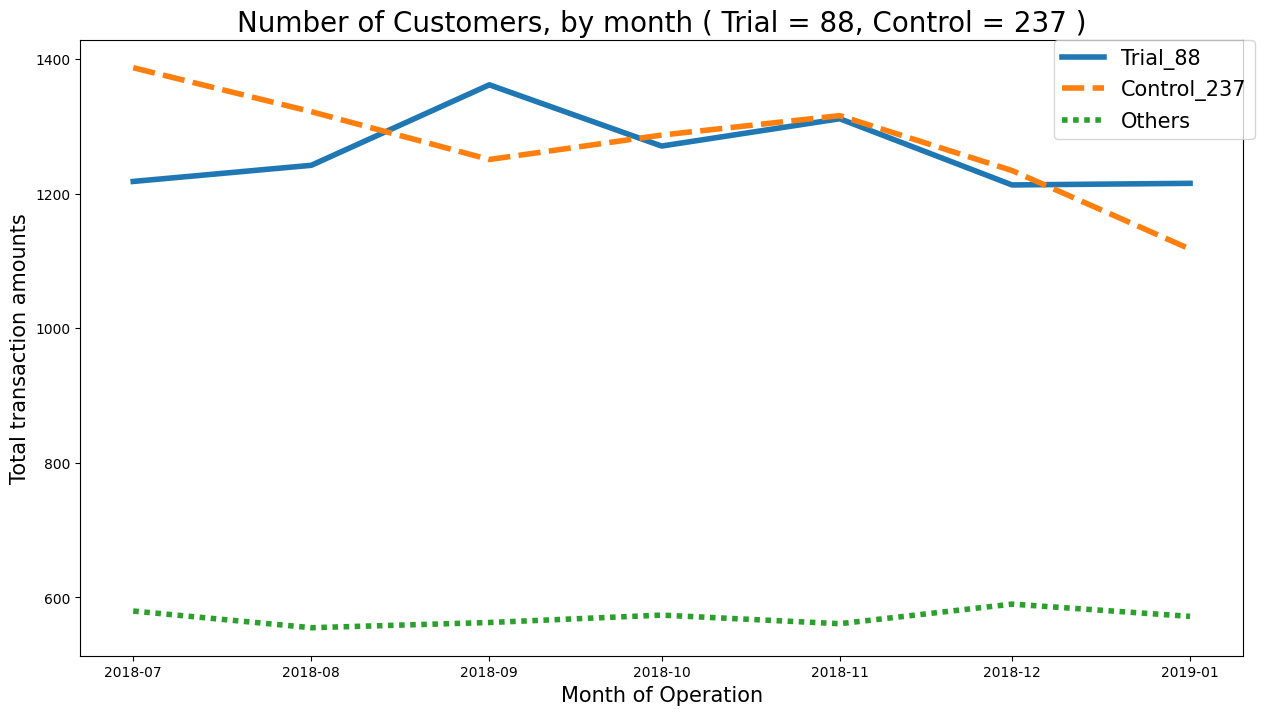

In [ ]:
# Visual checks on trends based on the drivers - total transaction amounts
b = pre_trial_period.set_index(["YEARMONTH","STORE_NBR"])["totSales"].unstack()
others_col = [i for i in b.columns if i not in [88, 237]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_88_c = b.loc[:,([88,237,"others"])].reset_index()
paired_88_c["YEARMONTH"]= pd.to_datetime(paired_88_c["YEARMONTH"], format="%Y%m")
paired_88_c = paired_88_c.set_index(["YEARMONTH"])
paired_88_c.columns=["Trial_88","Control_237","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 88, Control = 237 )",fontsize=20)
sns.lineplot(data=paired_88_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total transaction amounts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

Store 237 is the control store for trial store 88

# Assessment of trial

The trial period goes from the start of February 2019 to April 2019. We now want to
see if there has been an uplift in overall chip sales.
- We'll start with scaling the control store's sales to a level similar to control
for any differences between the two stores outside of the trial period.

## 1) Total transaction amounts

In [ ]:
# Scale pre-trial control sales to match pre-trial trial store sales
#Finding the scaling factor for control store

#Trial store 77 - Control store 233:
trial_value_77 = pre_trial_period[pre_trial_period['STORE_NBR']==77].agg({'totSales':'sum'})
control_value_233 = pre_trial_period[pre_trial_period['STORE_NBR']==233].agg({'totSales':'sum'})
scaling_factor_trial_77_control_233 = trial_value_77/control_value_233

#Trial store 86 - Control store 155:
trial_value_86 = pre_trial_period[pre_trial_period['STORE_NBR']==86].agg({'totSales':'sum'})
control_value_155 = pre_trial_period[pre_trial_period['STORE_NBR']==155].agg({'totSales':'sum'})
scaling_factor_trial_86_control_155 = trial_value_86/control_value_155

#Trial store 88 - Control store 237:
trial_value_88 = pre_trial_period[pre_trial_period['STORE_NBR']==88].agg({'totSales':'sum'})
control_value_237 = pre_trial_period[pre_trial_period['STORE_NBR']==237].agg({'totSales':'sum'})
scaling_factor_trial_88_control_237 = trial_value_88/control_value_237

In [ ]:
#Applying the scaling factor

df_group_ms = df_group_ms.astype({'YEARMONTH':'int'})
#Store 233:
scaledControlSales_233 = df_group_ms[['YEARMONTH','STORE_NBR','totSales']][(df_group_ms['STORE_NBR']==233)]
scaledControlSales_233['scaled_totSales'] = scaledControlSales_233['totSales']*scaling_factor_trial_77_control_233.values
scaledControlSales_233 = scaledControlSales_233.drop('totSales', axis=1)
scaledControlSales_233.rename(columns={"STORE_NBR": "Control_Store_NBR"}, inplace=True)

#Store 155:
scaledControlSales_155 = df_group_ms[['YEARMONTH','STORE_NBR','totSales']][(df_group_ms['STORE_NBR']==155)]
scaledControlSales_155['scaled_totSales'] = scaledControlSales_155['totSales']*scaling_factor_trial_86_control_155.values
scaledControlSales_155 = scaledControlSales_155.drop('totSales', axis=1)
scaledControlSales_155.rename(columns={"STORE_NBR": "Control_Store_NBR"}, inplace=True)

#Store 237:
scaledControlSales_237 = df_group_ms[['YEARMONTH','STORE_NBR','totSales']][(df_group_ms['STORE_NBR']==237)]
scaledControlSales_237['scaled_totSales'] = scaledControlSales_237['totSales']*scaling_factor_trial_88_control_237.values
scaledControlSales_237 = scaledControlSales_237.drop('totSales', axis=1)
scaledControlSales_237.rename(columns={"STORE_NBR": "Control_Store_NBR"}, inplace=True)

Now that we have comparable sales figures for the control store, we can calculate
the percentage difference between the scaled control sales and the trial store's
sales during the trial period.

In [ ]:
#First, filter data for trial store sales
#Store 77:
trial_sales_77 = df_group_ms[['YEARMONTH','STORE_NBR','totSales']][(df_group_ms['STORE_NBR']==77)]

#Store 86:
trial_sales_86 = df_group_ms[['YEARMONTH','STORE_NBR','totSales']][(df_group_ms['STORE_NBR']==86)]

#Store 88:
trial_sales_88 = df_group_ms[['YEARMONTH','STORE_NBR','totSales']][(df_group_ms['STORE_NBR']==88)]


In [ ]:
#Merge data from trial and control stores to calculate percentage difference

ts_77_cs_233 = pd.merge(trial_sales_77, scaledControlSales_233, on='YEARMONTH')
ts_86_cs_155 = pd.merge(trial_sales_86, scaledControlSales_155, on='YEARMONTH')
ts_88_cs_237 = pd.merge(trial_sales_88, scaledControlSales_237, on='YEARMONTH')
ts_77_cs_233

,YEARMONTH,STORE_NBR,totSales,Control_Store_NBR,scaled_totSales
0,201807,77,268.4,233,281.980841
1,201808,77,247.5,233,271.063441
2,201809,77,216.8,233,229.681297
3,201810,77,194.3,233,165.632551
4,201811,77,224.9,233,214.708863
5,201812,77,255.2,233,275.950277
6,201901,77,188.4,233,156.482731
7,201902,77,211.6,233,229.473346
8,201903,77,255.1,233,187.779277
9,201904,77,258.1,233,149.932291


In [ ]:
ts_77_cs_233['percentageDiff'] = abs(ts_77_cs_233['totSales'] - ts_77_cs_233['scaled_totSales']) / (ts_77_cs_233['scaled_totSales'])*100
ts_86_cs_155['percentageDiff'] = abs(ts_86_cs_155['totSales'] - ts_86_cs_155['scaled_totSales']) / (ts_86_cs_155['scaled_totSales'])*100
ts_88_cs_237['percentageDiff'] = abs(ts_88_cs_237['totSales'] - ts_88_cs_237['scaled_totSales']) / (ts_88_cs_237['scaled_totSales'])*100
ts_77_cs_233

,YEARMONTH,STORE_NBR,totSales,Control_Store_NBR,scaled_totSales,percentageDiff
0,201807,77,268.4,233,281.980841,4.816228
1,201808,77,247.5,233,271.063441,8.692962
2,201809,77,216.8,233,229.681297,5.608335
3,201810,77,194.3,233,165.632551,17.307859
4,201811,77,224.9,233,214.708863,4.746491
5,201812,77,255.2,233,275.950277,7.519571
6,201901,77,188.4,233,156.482731,20.396672
7,201902,77,211.6,233,229.473346,7.788855
8,201903,77,255.1,233,187.779277,35.850987
9,201904,77,258.1,233,149.932291,72.144372


Let's see if the difference is significant!

As our null hypothesis is that the trial period is the same as the pre-trial
period, let's take the standard deviation based on the scaled percentage difference
in the pre-trial period

Note that there are 7 months in the pre-trial period: Degree of freedom = 7

In [ ]:
# standard deviation of percentage difference in pre-trial period
std_cs_77 = ts_77_cs_233['percentageDiff'][ts_77_cs_233["YEARMONTH"]<201902].std()
std_cs_86 = ts_86_cs_155['percentageDiff'][ts_86_cs_155["YEARMONTH"]<201902].std()
std_cs_88 = ts_88_cs_237['percentageDiff'][ts_88_cs_237["YEARMONTH"]<201902].std()
std_cs_77

6.363898833418711

In [ ]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores.
#The test statistic here is (x - u)/standard deviation percentageDiff
# Calculate the t-values for the trial months.
ts_77_cs_233["tValue"] = (ts_77_cs_233["percentageDiff"]-0)/std_cs_77
ts_86_cs_155["tValue"] = (ts_86_cs_155["percentageDiff"]-0)/std_cs_77
ts_88_cs_237["tValue"] = (ts_88_cs_237["percentageDiff"]-0)/std_cs_77

ts_77_cs_233

,YEARMONTH,STORE_NBR,totSales,Control_Store_NBR,scaled_totSales,percentageDiff,tValue
0,201807,77,268.4,233,281.980841,4.816228,0.756805
1,201808,77,247.5,233,271.063441,8.692962,1.365980
2,201809,77,216.8,233,229.681297,5.608335,0.881273
3,201810,77,194.3,233,165.632551,17.307859,2.719694
4,201811,77,224.9,233,214.708863,4.746491,0.745846
5,201812,77,255.2,233,275.950277,7.519571,1.181598
6,201901,77,188.4,233,156.482731,20.396672,3.205059
7,201902,77,211.6,233,229.473346,7.788855,1.223912
8,201903,77,255.1,233,187.779277,35.850987,5.633494
9,201904,77,258.1,233,149.932291,72.144372,11.336505


In [ ]:
#t value of trial store 77 and control store 233
ts_77_cs_233
#We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April -
#i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

,YEARMONTH,STORE_NBR,totSales,Control_Store_NBR,scaled_totSales,percentageDiff,tValue
0,201807,77,268.4,233,281.980841,4.816228,0.756805
1,201808,77,247.5,233,271.063441,8.692962,1.365980
2,201809,77,216.8,233,229.681297,5.608335,0.881273
3,201810,77,194.3,233,165.632551,17.307859,2.719694
4,201811,77,224.9,233,214.708863,4.746491,0.745846
5,201812,77,255.2,233,275.950277,7.519571,1.181598
6,201901,77,188.4,233,156.482731,20.396672,3.205059
7,201902,77,211.6,233,229.473346,7.788855,1.223912
8,201903,77,255.1,233,187.779277,35.850987,5.633494
9,201904,77,258.1,233,149.932291,72.144372,11.336505


In [ ]:
# t value of trial store 86 and control store 155
ts_86_cs_155
#We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for April -
#i.e. the increase in sales in the trial store in April is statistically greater than in the control store;
#but for other months,we don't observe the difference.

,YEARMONTH,STORE_NBR,totSales,Control_Store_NBR,scaled_totSales,percentageDiff,tValue
0,201807,86,851.00,155,875.427669,2.790370,0.438469
1,201808,86,726.85,155,718.052875,1.225136,0.192513
2,201809,86,855.00,155,913.337595,6.387298,1.003677
3,201810,86,898.80,155,888.453131,1.164594,0.183000
4,201811,86,851.20,155,811.661230,4.871339,0.765465
5,201812,86,812.20,155,777.445092,4.470400,0.702463
6,201901,86,800.60,155,811.272410,1.315515,0.206715
7,201902,86,872.80,155,827.019610,5.535587,0.869842
8,201903,86,945.40,155,745.561872,26.803695,4.211835
9,201904,86,804.00,155,778.028321,3.338141,0.524543


In [ ]:
# t value of trial store 88 and control store 237
ts_88_cs_237
#We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April -
#i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

,YEARMONTH,STORE_NBR,totSales,Control_Store_NBR,scaled_totSales,percentageDiff,tValue
0,201807,88,1218.20,237,1374.394024,11.364574,1.785788
1,201808,88,1242.20,237,1309.696842,5.153623,0.809822
2,201809,88,1361.80,237,1239.253204,9.888762,1.553884
3,201810,88,1270.80,237,1275.218100,0.346458,0.054441
4,201811,88,1311.40,237,1303.851308,0.578953,0.090975
5,201812,88,1213.00,237,1223.004601,0.818035,0.128543
6,201901,88,1215.40,237,1107.381921,9.754365,1.532766
7,201902,88,1339.60,237,1300.879003,2.976526,0.467720
8,201903,88,1467.00,237,1166.728952,25.736144,4.044084
9,201904,88,1317.00,237,1142.950509,15.228086,2.392886


In [ ]:
# Critical value under 95% confidence & degree of freedom = 7
t.ppf(0.975,df=7)

2.3646242510102993

Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

In [ ]:
# Control store 95th percentile
ts_77_cs_233['CI_95_pct_control_sales']=ts_77_cs_233['scaled_totSales']*(1+(std_cs_77/100*2))
ts_86_cs_155['CI_95_pct_control_sales']=ts_86_cs_155['scaled_totSales']*(1+(std_cs_86/100*2))
ts_88_cs_237['CI_95_pct_control_sales']=ts_88_cs_237['scaled_totSales']*(1+(std_cs_88/100*2))

ts_77_cs_233

,YEARMONTH,STORE_NBR,totSales,Control_Store_NBR,scaled_totSales,percentageDiff,tValue,CI_95_pct_control_sales
0,201807,77,268.4,233,281.980841,4.816228,0.756805,317.870792
1,201808,77,247.5,233,271.063441,8.692962,1.365980,305.563847
2,201809,77,216.8,233,229.681297,5.608335,0.881273,258.914668
3,201810,77,194.3,233,165.632551,17.307859,2.719694,186.713927
4,201811,77,224.9,233,214.708863,4.746491,0.745846,242.036572
5,201812,77,255.2,233,275.950277,7.519571,1.181598,311.072670
6,201901,77,188.4,233,156.482731,20.396672,3.205059,176.399536
7,201902,77,211.6,233,229.473346,7.788855,1.223912,258.680250
8,201903,77,255.1,233,187.779277,35.850987,5.633494,211.679443
9,201904,77,258.1,233,149.932291,72.144372,11.336505,169.015369


In [ ]:
# Control store 5th percentile
ts_77_cs_233['CI_5_pct_control_sales']=ts_77_cs_233['scaled_totSales']*(1-(std_cs_77/100*2))
ts_86_cs_155['CI_5_pct_control_sales']=ts_86_cs_155['scaled_totSales']*(1-(std_cs_86/100*2))
ts_88_cs_237['CI_5_pct_control_sales']=ts_88_cs_237['scaled_totSales']*(1-(std_cs_88/100*2))

ts_77_cs_233

,YEARMONTH,STORE_NBR,totSales,Control_Store_NBR,scaled_totSales,percentageDiff,tValue,CI_95_pct_control_sales,CI_5_pct_control_sales
0,201807,77,268.4,233,281.980841,4.816228,0.756805,317.870792,246.090890
1,201808,77,247.5,233,271.063441,8.692962,1.365980,305.563847,236.563035
2,201809,77,216.8,233,229.681297,5.608335,0.881273,258.914668,200.447926
3,201810,77,194.3,233,165.632551,17.307859,2.719694,186.713927,144.551175
4,201811,77,224.9,233,214.708863,4.746491,0.745846,242.036572,187.381153
5,201812,77,255.2,233,275.950277,7.519571,1.181598,311.072670,240.827884
6,201901,77,188.4,233,156.482731,20.396672,3.205059,176.399536,136.565925
7,201902,77,211.6,233,229.473346,7.788855,1.223912,258.680250,200.266443
8,201903,77,255.1,233,187.779277,35.850987,5.633494,211.679443,163.879110
9,201904,77,258.1,233,149.932291,72.144372,11.336505,169.015369,130.849212


In [ ]:
# Plotting these in one nice graph
plot_77_sales = ts_77_cs_233
plot_77_sales["YEARMONTH"] = plot_77_sales["YEARMONTH"].astype("str")
plot_77_sales.rename(columns={'totSales': 'Trial_Store_77_Sales','scaled_totSales':'Control_Store_233_Sales'},inplace=True)
plot_77_sales = plot_77_sales.set_index("YEARMONTH")

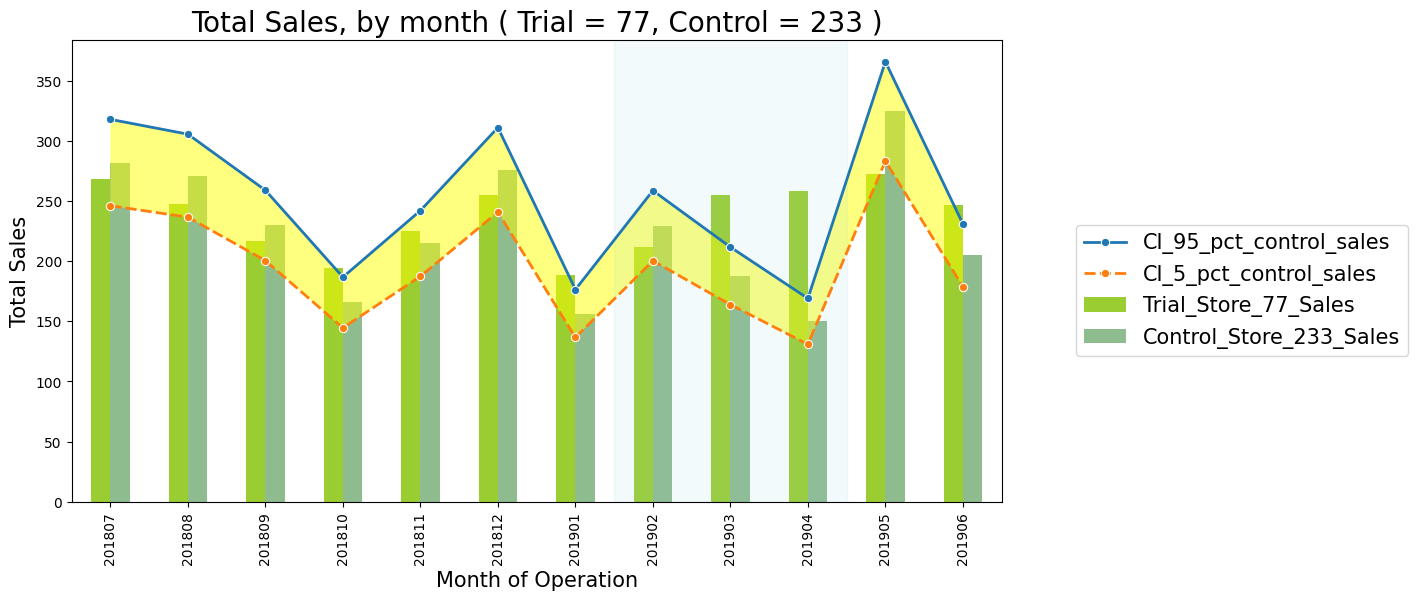

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create bar charts for Trial_Store_77_Sales and Control_Store_233_Sales

plot_77_sales[['Trial_Store_77_Sales', 'Control_Store_233_Sales']].plot(kind='bar', ax=ax, color=['yellowgreen', 'darkseagreen'])

# Plot line charts for CI_95_pct_control_sales and CI_5_pct_control_sales with red dots
sns.lineplot(data=plot_77_sales[['CI_95_pct_control_sales', 'CI_5_pct_control_sales']],
             ax=ax, linewidth=2, color='red', marker='o')
# Fill the area between the confidence intervals with yellow
ax.fill_between(plot_77_sales.index,
                 plot_77_sales["CI_95_pct_control_sales"], plot_77_sales["CI_5_pct_control_sales"],
                 facecolor="yellow", alpha=0.5)

# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.1)
plt.title("Total Sales, by month ( Trial = 77, Control = 233 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total Sales", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside far from the 5% to 95% confidence interval of the control store in two of the three trial months.

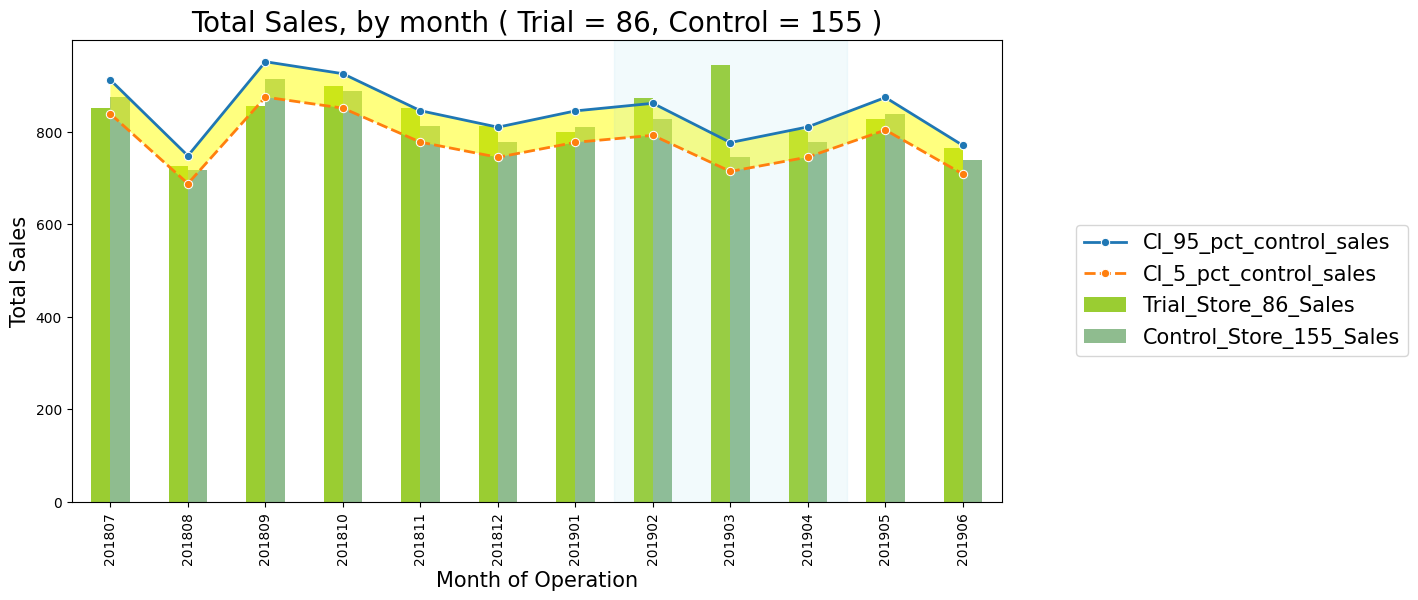

In [ ]:
# Plotting these in one nice graph
plot_86_sales = ts_86_cs_155
plot_86_sales["YEARMONTH"] = plot_86_sales["YEARMONTH"].astype("str")
plot_86_sales.rename(columns={'totSales': 'Trial_Store_86_Sales','scaled_totSales':'Control_Store_155_Sales'},inplace=True)
plot_86_sales = plot_86_sales.set_index("YEARMONTH")
fig, ax = plt.subplots(figsize=(12, 6))

# Create bar charts for Trial_Store_86_Sales and Control_Store_155_Sales

plot_86_sales[['Trial_Store_86_Sales', 'Control_Store_155_Sales']].plot(kind='bar', ax=ax, color=['yellowgreen', 'darkseagreen'])

# Plot line charts for CI_95_pct_control_sales and CI_5_pct_control_sales with red dots
sns.lineplot(data=plot_86_sales[['CI_95_pct_control_sales', 'CI_5_pct_control_sales']],
             ax=ax, linewidth=2, color='red', marker='o')
# Fill the area between the confidence intervals with yellow
ax.fill_between(plot_86_sales.index,
                 plot_86_sales["CI_95_pct_control_sales"], plot_86_sales["CI_5_pct_control_sales"],
                 facecolor="yellow", alpha=0.5)

# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.1)
plt.title("Total Sales, by month ( Trial = 86, Control = 155 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total Sales", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)

The results show that the trial in store 86 is significantly different to its control store in the trial period as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.

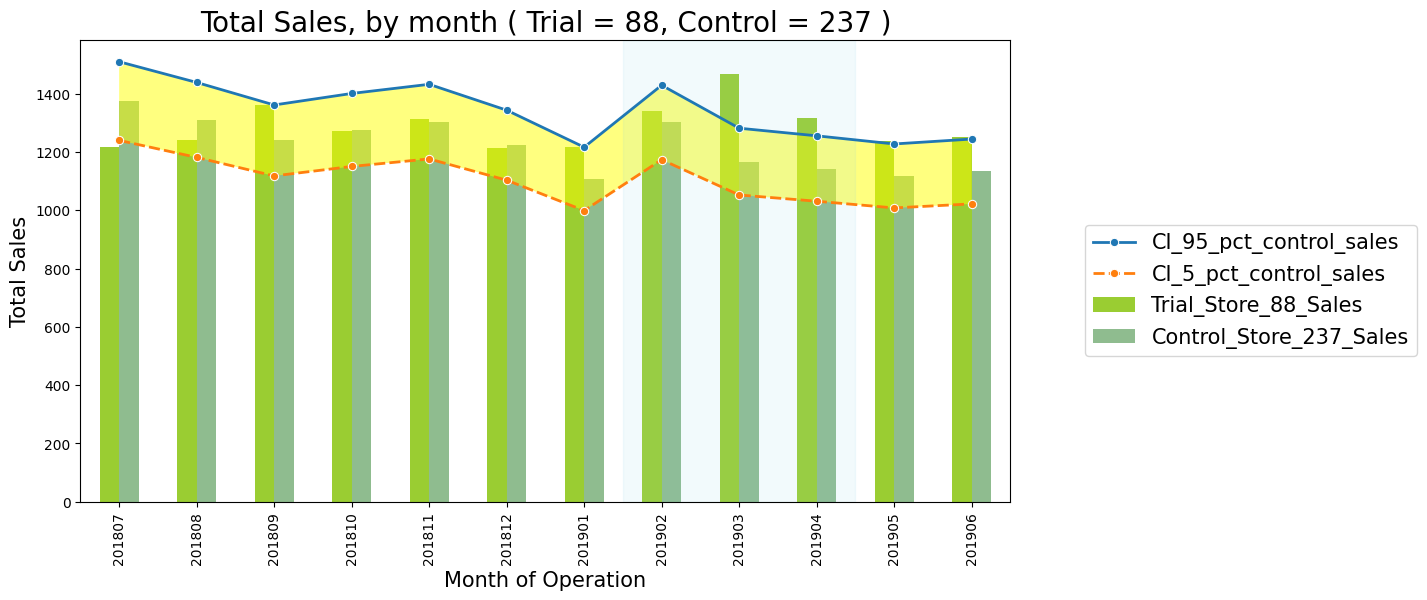

In [ ]:
# Plotting these in one nice graph
plot_88_sales = ts_88_cs_237
plot_88_sales["YEARMONTH"] = plot_88_sales["YEARMONTH"].astype("str")
plot_88_sales.rename(columns={'totSales': 'Trial_Store_88_Sales','scaled_totSales':'Control_Store_237_Sales'},inplace=True)
plot_88_sales = plot_88_sales.set_index("YEARMONTH")
fig, ax = plt.subplots(figsize=(12, 6))

# Create bar charts for Trial_Store_88_Sales and Control_Store_237_Sales

plot_88_sales[['Trial_Store_88_Sales', 'Control_Store_237_Sales']].plot(kind='bar', ax=ax, color=['yellowgreen', 'darkseagreen'])

# Plot line charts for CI_95_pct_control_sales and CI_5_pct_control_sales with red dots
sns.lineplot(data=plot_88_sales[['CI_95_pct_control_sales', 'CI_5_pct_control_sales']],
             ax=ax, linewidth=2, color='red', marker='o')
# Fill the area between the confidence intervals with yellow
ax.fill_between(plot_88_sales.index,
                 plot_88_sales["CI_95_pct_control_sales"], plot_88_sales["CI_5_pct_control_sales"],
                 facecolor="yellow", alpha=0.5)

# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.1)
plt.title("Total Sales, by month ( Trial = 88, Control = 237 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total Sales", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)

The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.

## 2) Number of customers

In [ ]:
#Let's have a look at assessing this for number of customers as well.
# Scale pre-trial control num customers to match pre-trial trial store num customer
#Finding the scaling factor for control store

#Trial store 77 - Control store 233:
trial_value_77 = pre_trial_period[pre_trial_period['STORE_NBR']==77].agg({'nCustomers':'sum'})
control_value_233 = pre_trial_period[pre_trial_period['STORE_NBR']==233].agg({'nCustomers':'sum'})
scaling_factor_trial_77_control_233 = trial_value_77/control_value_233

#Trial store 86 - Control store 155:
trial_value_86 = pre_trial_period[pre_trial_period['STORE_NBR']==86].agg({'nCustomers':'sum'})
control_value_155 = pre_trial_period[pre_trial_period['STORE_NBR']==155].agg({'nCustomers':'sum'})
scaling_factor_trial_86_control_155 = trial_value_86/control_value_155

#Trial store 88 - Control store 237:
trial_value_88 = pre_trial_period[pre_trial_period['STORE_NBR']==88].agg({'nCustomers':'sum'})
control_value_237 = pre_trial_period[pre_trial_period['STORE_NBR']==237].agg({'nCustomers':'sum'})
scaling_factor_trial_88_control_237 = trial_value_88/control_value_237

In [ ]:
#Applying the scaling factor

df_group_ms = df_group_ms.astype({'YEARMONTH':'int'})
#Store 233:
scaledControlCusts_233 = df_group_ms[['YEARMONTH','STORE_NBR','nCustomers']][(df_group_ms['STORE_NBR']==233)]
scaledControlCusts_233['scaled_nCustomers'] = scaledControlCusts_233['nCustomers']*scaling_factor_trial_77_control_233.values
scaledControlCusts_233 = scaledControlCusts_233.drop('nCustomers', axis=1)
scaledControlCusts_233.rename(columns={"STORE_NBR": "Control_Store_NBR"}, inplace=True)

#Store 155:
scaledControlCusts_155 = df_group_ms[['YEARMONTH','STORE_NBR','nCustomers']][(df_group_ms['STORE_NBR']==155)]
scaledControlCusts_155['scaled_nCustomers'] = scaledControlCusts_155['nCustomers']*scaling_factor_trial_86_control_155.values
scaledControlCusts_155 = scaledControlCusts_155.drop('nCustomers', axis=1)
scaledControlCusts_155.rename(columns={"STORE_NBR": "Control_Store_NBR"}, inplace=True)

#Store 237:
scaledControlCusts_237 = df_group_ms[['YEARMONTH','STORE_NBR','nCustomers']][(df_group_ms['STORE_NBR']==237)]
scaledControlCusts_237['scaled_nCustomers'] = scaledControlCusts_237['nCustomers']*scaling_factor_trial_88_control_237.values
scaledControlCusts_237 = scaledControlCusts_237.drop('nCustomers', axis=1)
scaledControlCusts_237.rename(columns={"STORE_NBR": "Control_Store_NBR"}, inplace=True)

Now that we have comparable number of customers figures for the control store, we can calculate the percentage difference between the scaled control number of custs and the trial store's number of custs during the trial period.

In [ ]:
#First, filter data for trial store number of customers
#Store 77:
trial_custs_77 = df_group_ms[['YEARMONTH','STORE_NBR','nCustomers']][(df_group_ms['STORE_NBR']==77)]

#Store 86:
trial_custs_86 = df_group_ms[['YEARMONTH','STORE_NBR','nCustomers']][(df_group_ms['STORE_NBR']==86)]

#Store 88:
trial_custs_88 = df_group_ms[['YEARMONTH','STORE_NBR','nCustomers']][(df_group_ms['STORE_NBR']==88)]

In [ ]:
#Merge data from trial and control stores to calculate percentage difference

ts_77_cs_233 = pd.merge(trial_custs_77, scaledControlCusts_233, on='YEARMONTH')
ts_86_cs_155 = pd.merge(trial_custs_86, scaledControlCusts_155, on='YEARMONTH')
ts_88_cs_237 = pd.merge(trial_custs_88, scaledControlCusts_237, on='YEARMONTH')
ts_88_cs_237

,YEARMONTH,STORE_NBR,nCustomers,Control_Store_NBR,scaled_nCustomers
0,201807,88,124,237,124.413146
1,201808,88,125,237,131.380282
2,201809,88,121,237,119.436620
3,201810,88,120,237,117.446009
4,201811,88,123,237,124.413146
5,201812,88,120,237,120.431925
6,201901,88,115,237,110.478873
7,201902,88,122,237,118.441315
8,201903,88,133,237,115.455399
9,201904,88,119,237,115.455399


In [ ]:
ts_77_cs_233['percentageDiff'] = abs(ts_77_cs_233['nCustomers'] - ts_77_cs_233['scaled_nCustomers']) / (ts_77_cs_233['scaled_nCustomers'])*100
ts_86_cs_155['percentageDiff'] = abs(ts_86_cs_155['nCustomers'] - ts_86_cs_155['scaled_nCustomers']) / (ts_86_cs_155['scaled_nCustomers'])*100
ts_88_cs_237['percentageDiff'] = abs(ts_88_cs_237['nCustomers'] - ts_88_cs_237['scaled_nCustomers']) / (ts_88_cs_237['scaled_nCustomers'])*100
ts_77_cs_233

,YEARMONTH,STORE_NBR,nCustomers,Control_Store_NBR,scaled_nCustomers,percentageDiff
0,201807,77,47,233,48.021739,2.127660
1,201808,77,46,233,44.956522,2.321083
2,201809,77,40,233,40.869565,2.127660
3,201810,77,36,233,32.695652,10.106383
4,201811,77,39,233,39.847826,2.127660
5,201812,77,43,233,43.934783,2.127660
6,201901,77,31,233,31.673913,2.127660
7,201902,77,40,233,42.913043,6.788247
8,201903,77,46,233,35.760870,28.632219
9,201904,77,47,233,27.586957,70.370370


Let's see if the difference is significant!




As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period

Note that there are 7 months in the pre-trial period: Degree of freedom = 7

In [ ]:
# standard deviation of percentage difference in pre-trial period
std_cs_77 = ts_77_cs_233['percentageDiff'][ts_77_cs_233["YEARMONTH"]<201902].std()
std_cs_86 = ts_86_cs_155['percentageDiff'][ts_86_cs_155["YEARMONTH"]<201902].std()
std_cs_88 = ts_88_cs_237['percentageDiff'][ts_88_cs_237["YEARMONTH"]<201902].std()
std_cs_77

3.00435434917479

In [ ]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores.
#The test statistic here is (x - u)/standard deviation percentageDiff
# Calculate the t-values for the trial months.
ts_77_cs_233["tValue"] = (ts_77_cs_233["percentageDiff"]-0)/std_cs_77
ts_86_cs_155["tValue"] = (ts_86_cs_155["percentageDiff"]-0)/std_cs_77
ts_88_cs_237["tValue"] = (ts_88_cs_237["percentageDiff"]-0)/std_cs_77

In [ ]:
# t value of trial store 77 and control store 233
ts_77_cs_233
#We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April -
# i.e. the increase in number of customers in the trial store 77 in March and April is statistically greater than in the control store 233.

,YEARMONTH,STORE_NBR,nCustomers,Control_Store_NBR,scaled_nCustomers,percentageDiff,tValue
0,201807,77,47,233,48.021739,2.127660,0.708192
1,201808,77,46,233,44.956522,2.321083,0.772573
2,201809,77,40,233,40.869565,2.127660,0.708192
3,201810,77,36,233,32.695652,10.106383,3.363912
4,201811,77,39,233,39.847826,2.127660,0.708192
5,201812,77,43,233,43.934783,2.127660,0.708192
6,201901,77,31,233,31.673913,2.127660,0.708192
7,201902,77,40,233,42.913043,6.788247,2.259470
8,201903,77,46,233,35.760870,28.632219,9.530240
9,201904,77,47,233,27.586957,70.370370,23.422793


In [ ]:
# t value of trial store 86 and control store 155
ts_86_cs_155
#We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March -
#i.e. the increase in sales in the trial store in March is statistically greater than in the control store,
#but for other months we dont see the clear difference.

,YEARMONTH,STORE_NBR,nCustomers,Control_Store_NBR,scaled_nCustomers,percentageDiff,tValue
0,201807,86,94,155,98.294294,4.368813,1.454160
1,201808,86,92,155,88.264264,4.232444,1.408770
2,201809,86,100,155,96.288288,3.854790,1.283068
3,201810,86,105,155,105.315315,0.299401,0.099656
4,201811,86,95,155,96.288288,1.337949,0.445337
5,201812,86,93,155,91.273273,1.891821,0.629693
6,201901,86,89,155,92.276276,3.550508,1.181787
7,201902,86,105,155,92.276276,13.788727,4.589581
8,201903,86,108,155,91.273273,18.325985,6.099808
9,201904,86,99,155,93.279279,6.132895,2.041336


In [ ]:
# t value of trial store 88 and control store 237
ts_88_cs_237
#We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March -
#i.e. the increase in sales in the trial store in March is statistically greater than in the control store,
# for other months, we don't see a clear difference.

,YEARMONTH,STORE_NBR,nCustomers,Control_Store_NBR,scaled_nCustomers,percentageDiff,tValue
0,201807,88,124,237,124.413146,0.332075,0.110531
1,201808,88,125,237,131.380282,4.856346,1.616436
2,201809,88,121,237,119.436620,1.308962,0.435688
3,201810,88,120,237,117.446009,2.174608,0.723819
4,201811,88,123,237,124.413146,1.135849,0.378068
5,201812,88,120,237,120.431925,0.358646,0.119376
6,201901,88,115,237,110.478873,4.092300,1.362123
7,201902,88,122,237,118.441315,3.004598,1.000081
8,201903,88,133,237,115.455399,15.195999,5.057991
9,201904,88,119,237,115.455399,3.070104,1.021885


In [ ]:
# Critical value under 95% confidence & degree of freedom = 7
t.ppf(0.975,df=7)

2.3646242510102993



Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

In [ ]:
# Control store 95th percentile
ts_77_cs_233['CI_95_pct_control_custs']=ts_77_cs_233['scaled_nCustomers']*(1+(std_cs_77/100*2))
ts_86_cs_155['CI_95_pct_control_custs']=ts_86_cs_155['scaled_nCustomers']*(1+(std_cs_86/100*2))
ts_88_cs_237['CI_95_pct_control_custs']=ts_88_cs_237['scaled_nCustomers']*(1+(std_cs_88/100*2))

ts_77_cs_233

,YEARMONTH,STORE_NBR,nCustomers,Control_Store_NBR,scaled_nCustomers,percentageDiff,tValue,CI_95_pct_control_custs
0,201807,77,47,233,48.021739,2.127660,0.708192,50.907226
1,201808,77,46,233,44.956522,2.321083,0.772573,47.657828
2,201809,77,40,233,40.869565,2.127660,0.708192,43.325298
3,201810,77,36,233,32.695652,10.106383,3.363912,34.660239
4,201811,77,39,233,39.847826,2.127660,0.708192,42.242166
5,201812,77,43,233,43.934783,2.127660,0.708192,46.574696
6,201901,77,31,233,31.673913,2.127660,0.708192,33.577106
7,201902,77,40,233,42.913043,6.788247,2.259470,45.491563
8,201903,77,46,233,35.760870,28.632219,9.530240,37.909636
9,201904,77,47,233,27.586957,70.370370,23.422793,29.244576


In [ ]:
# Control store 5th percentile
ts_77_cs_233['CI_5_pct_control_custs']=ts_77_cs_233['scaled_nCustomers']*(1-(std_cs_77/100*2))
ts_86_cs_155['CI_5_pct_control_custs']=ts_86_cs_155['scaled_nCustomers']*(1-(std_cs_86/100*2))
ts_88_cs_237['CI_5_pct_control_custs']=ts_88_cs_237['scaled_nCustomers']*(1-(std_cs_88/100*2))

ts_77_cs_233

,YEARMONTH,STORE_NBR,nCustomers,Control_Store_NBR,scaled_nCustomers,percentageDiff,tValue,CI_95_pct_control_custs,CI_5_pct_control_custs
0,201807,77,47,233,48.021739,2.127660,0.708192,50.907226,45.136253
1,201808,77,46,233,44.956522,2.321083,0.772573,47.657828,42.255215
2,201809,77,40,233,40.869565,2.127660,0.708192,43.325298,38.413832
3,201810,77,36,233,32.695652,10.106383,3.363912,34.660239,30.731066
4,201811,77,39,233,39.847826,2.127660,0.708192,42.242166,37.453486
5,201812,77,43,233,43.934783,2.127660,0.708192,46.574696,41.294870
6,201901,77,31,233,31.673913,2.127660,0.708192,33.577106,29.770720
7,201902,77,40,233,42.913043,6.788247,2.259470,45.491563,40.334524
8,201903,77,46,233,35.760870,28.632219,9.530240,37.909636,33.612103
9,201904,77,47,233,27.586957,70.370370,23.422793,29.244576,25.929337


In [ ]:
# Plotting these in one nice graph
plot_77_custs = ts_77_cs_233
plot_77_custs["YEARMONTH"] = plot_77_custs["YEARMONTH"].astype("str")
plot_77_custs.rename(columns={'nCustomers': 'Trial_Store_77_No_Customers','scaled_nCustomers':'Control_Store_233_No_Customers'},inplace=True)
plot_77_custs = plot_77_custs.set_index("YEARMONTH")

plot_77_custs



,STORE_NBR,Trial_Store_77_No_Customers,Control_Store_NBR,Control_Store_233_No_Customers,percentageDiff,tValue,CI_95_pct_control_custs,CI_5_pct_control_custs
YEARMONTH,,,,,,,,
201807,77,47,233,48.021739,2.127660,0.708192,50.907226,45.136253
201808,77,46,233,44.956522,2.321083,0.772573,47.657828,42.255215
201809,77,40,233,40.869565,2.127660,0.708192,43.325298,38.413832
201810,77,36,233,32.695652,10.106383,3.363912,34.660239,30.731066
201811,77,39,233,39.847826,2.127660,0.708192,42.242166,37.453486
201812,77,43,233,43.934783,2.127660,0.708192,46.574696,41.294870
201901,77,31,233,31.673913,2.127660,0.708192,33.577106,29.770720
201902,77,40,233,42.913043,6.788247,2.259470,45.491563,40.334524
201903,77,46,233,35.760870,28.632219,9.530240,37.909636,33.612103


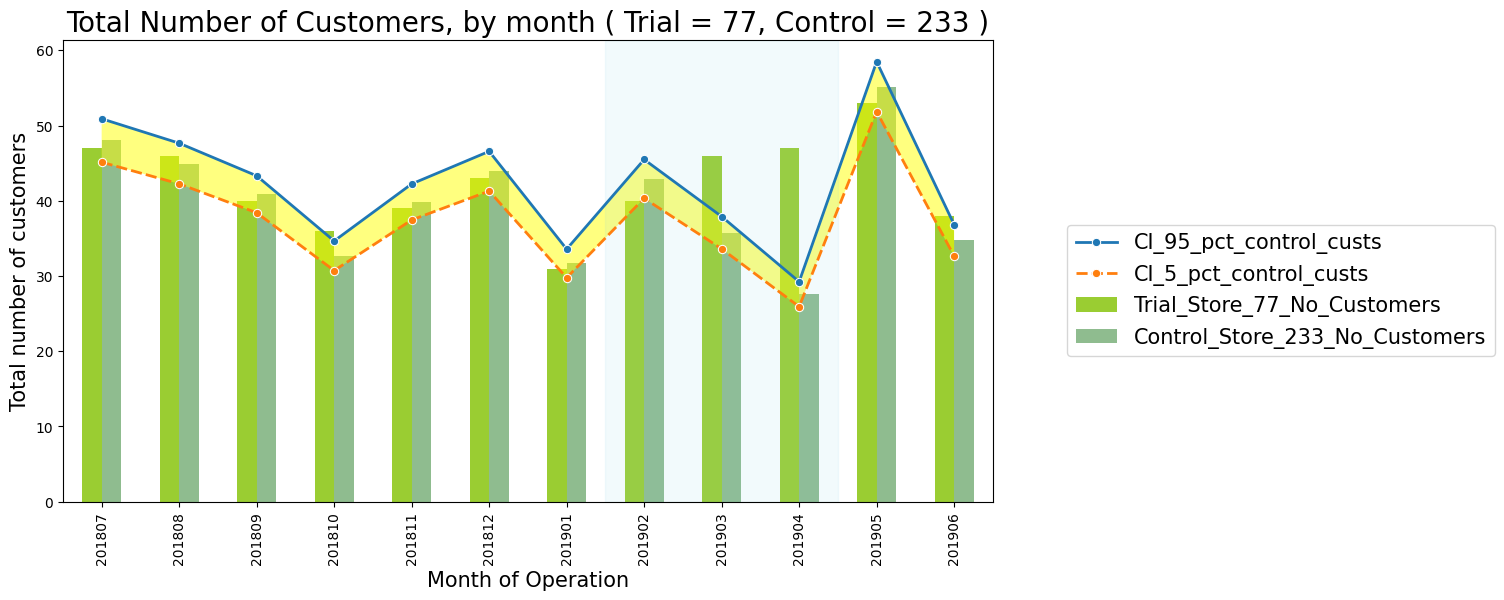

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
# Create bar charts for Trial_Store_77_No_Customers and Control_Store_233_No_Customers

plot_77_custs[['Trial_Store_77_No_Customers', 'Control_Store_233_No_Customers']].plot(kind='bar', ax=ax, color=['yellowgreen', 'darkseagreen'])

# Plot line charts for CI_95_pct_control_custs and CI_5_pct_control_custs with red dots
sns.lineplot(data=plot_77_custs[['CI_95_pct_control_custs', 'CI_5_pct_control_custs']],
             ax=ax, linewidth=2, color='red', marker='o')
# Fill the area between the confidence intervals with yellow
ax.fill_between(plot_77_custs.index,
                 plot_77_custs["CI_95_pct_control_custs"], plot_77_custs["CI_5_pct_control_custs"],
                 facecolor="yellow", alpha=0.5)

# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.1)
plt.title("Total Number of Customers, by month ( Trial = 77, Control = 233 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total number of customers", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)




The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside far from the 5% to 95% confidence interval of the control store in two of the three trial months.

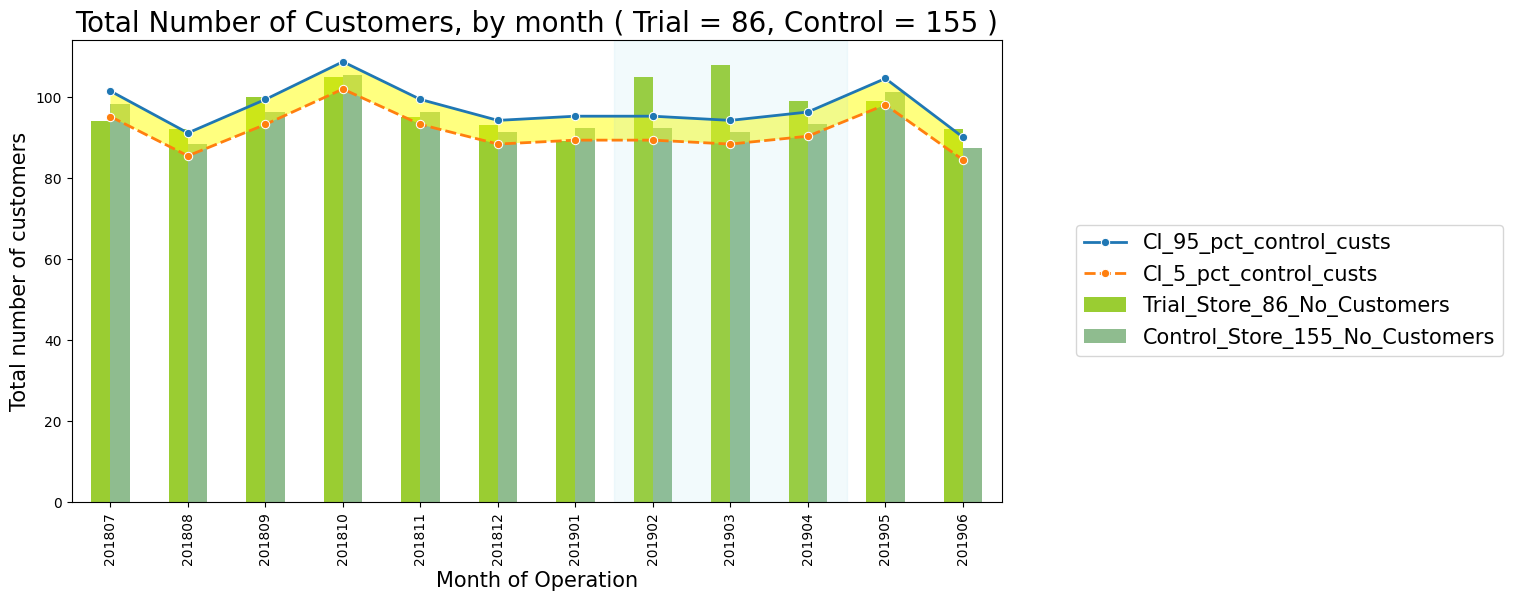

In [ ]:
# Plotting these in one nice graph
plot_86_custs = ts_86_cs_155
plot_86_custs["YEARMONTH"] = plot_86_custs["YEARMONTH"].astype("str")
plot_86_custs.rename(columns={'nCustomers': 'Trial_Store_86_No_Customers','scaled_nCustomers':'Control_Store_155_No_Customers'},inplace=True)
plot_86_custs = plot_86_custs.set_index("YEARMONTH")
fig, ax = plt.subplots(figsize=(12, 6))
# Create bar charts for Trial_Store_86_No_Customers and Control_Store_155_No_Customers

plot_86_custs[['Trial_Store_86_No_Customers', 'Control_Store_155_No_Customers']].plot(kind='bar', ax=ax, color=['yellowgreen', 'darkseagreen'])

# Plot line charts for CI_95_pct_control_custs and CI_5_pct_control_custs with red dots
sns.lineplot(data=plot_86_custs[['CI_95_pct_control_custs', 'CI_5_pct_control_custs']],
             ax=ax, linewidth=2, color='red', marker='o')
# Fill the area between the confidence intervals with yellow
ax.fill_between(plot_86_custs.index,
                 plot_86_custs["CI_95_pct_control_custs"], plot_86_custs["CI_5_pct_control_custs"],
                 facecolor="yellow", alpha=0.5)

# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.1)
plt.title("Total Number of Customers, by month ( Trial = 86, Control = 155 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total number of customers", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)

The results show that the trial in store 86 is significantly different to its control store in the trial period as the trial store performance lies outside far from the 5% to 95% confidence interval of the control store in three trial months.

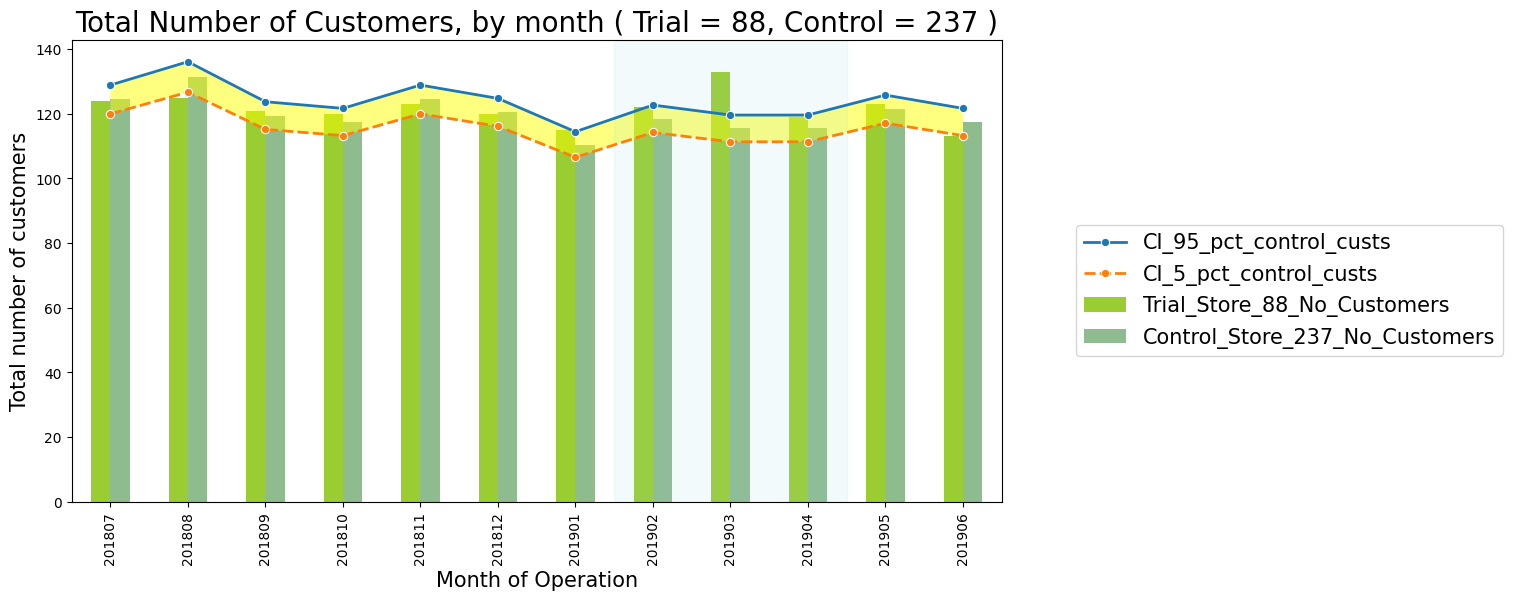

In [ ]:
# Plotting these in one nice graph
plot_88_custs = ts_88_cs_237
plot_88_custs["YEARMONTH"] = plot_88_custs["YEARMONTH"].astype("str")
plot_88_custs.rename(columns={'nCustomers': 'Trial_Store_88_No_Customers','scaled_nCustomers':'Control_Store_237_No_Customers'},inplace=True)
plot_88_custs = plot_88_custs.set_index("YEARMONTH")
fig, ax = plt.subplots(figsize=(12, 6))
# Create bar charts for Trial_Store_88_No_Customers and Control_Store_237_No_Customers

plot_88_custs[['Trial_Store_88_No_Customers', 'Control_Store_237_No_Customers']].plot(kind='bar', ax=ax, color=['yellowgreen', 'darkseagreen'])

# Plot line charts for CI_95_pct_control_custs and CI_5_pct_control_custs with red dots
sns.lineplot(data=plot_88_custs[['CI_95_pct_control_custs', 'CI_5_pct_control_custs']],
             ax=ax, linewidth=2, color='red', marker='o')
# Fill the area between the confidence intervals with yellow
ax.fill_between(plot_88_custs.index,
                 plot_88_custs["CI_95_pct_control_custs"], plot_88_custs["CI_5_pct_control_custs"],
                 facecolor="yellow", alpha=0.5)

# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.1)
plt.title("Total Number of Customers, by month ( Trial = 88, Control = 237 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total number of customers", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)

The results show that the trial in store 88 is significantly different to its control store only in the first month, but not different for 2 months after that

# Main Insights

We've found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. Now that we have finished our analysis, we can prepare our presentation to the Category Manager.